In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import json
import torch
import re
import pickle
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook
# from khaiii import KhaiiiApi

# 형태소 분석기, Korbert

### 형태소 분석기 Kaiii 설치

In [ ]:
!git clone https://github.com/kakao/khaiii.git
!mkdir build
!cmake khaiii/build/..
!make all khaiii/build
!make large_resource khaiii/build
!make package_python
!pip install package_python/.

Cloning into 'khaiii'...
remote: Enumerating objects: 877, done.
remote: Total 877 (delta 0), reused 0 (delta 0), pack-reused 877
Receiving objects: 100% (877/877), 30.21 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (358/358), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX comp

### Kaiii 사용법

In [ ]:
from khaiii import KhaiiiApi

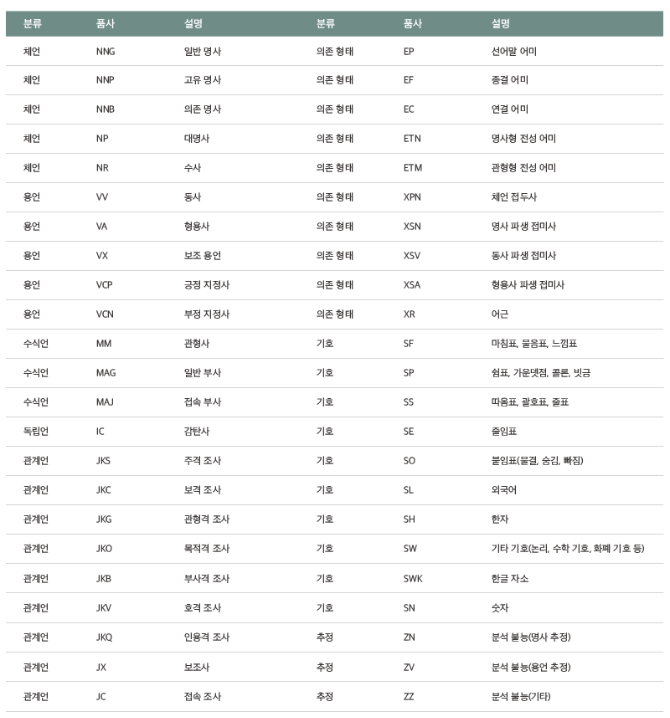

In [ ]:
tokenizer = KhaiiiApi()
a = tokenizer.analyze('대학로의 동숭아트센터에선 참 특이하고 낯선 그러면서도 기특한 광경이 벌어졌다')  # 공백 단위로 tokenizing

b = a[0]                                            
b.begin   # text에서 해당 token index
b.length  # token 길이
b.lex     # token
b.morphs  # token 형태소 분석

c = b.morphs[0]
c.begin   # token에서 해당 형태소 index
c.length  # 형태소 길이
c.lex     # 형태소
c.tag     # 형태소 분석 결과

'NNP'

In [ ]:
for i in a:
  print(i)

대학로의	대학로/NNP + 의/JKG
동숭아트센터에선	동숭아트센터/NNP + 에서/JKB + ㄴ/JX
참	참/MAG
특이하고	특이/NNG + 하/XSA + 고/EC
낯선	낯설/VA + ㄴ/ETM
그러면서도	그러/VV + 면서/EC + 도/JX
기특한	기특/XR + 하/XSA + ㄴ/ETM
광경이	광경/NNG + 이/JKS
벌어졌다	벌어지/VV + 었/EP + 다/EC


### Korbert 확인

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/korbert/bert_config.json') as json_file:
    korbert_config = json.load(json_file)
    
korbert_config   # hyper parameter

{'attention_probs_dropout_prob': 0.1,
 'directionality': 'bidi',
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'pooler_fc_size': 768,
 'pooler_num_attention_heads': 12,
 'pooler_num_fc_layers': 3,
 'pooler_size_per_head': 128,
 'pooler_type': 'first_token_transform',
 'type_vocab_size': 2,
 'vocab_size': 30349}

In [ ]:
# 형태소 분석 토큰
with open('/content/drive/My Drive/tobigs/poetry_generater/korbert/vocab.korean_morp.list', 'r') as f:
  kor_morp = f.readlines()

In [ ]:
len(kor_morp)

30351

In [ ]:
kor_morp

['n_iters=10000\n',
 'max_length=16\n',
 '[PAD]\n',
 '[UNK]\n',
 '[CLS]\n',
 '[SEP]\n',
 '[MASK]\n',
 '<S>\n',
 '<T>\n',
 './SF_\t20688850\n',
 '다/EF_\t17194907\n',
 '하/XSV_\t15918761\n',
 'ㄴ/ETM_\t13942053\n',
 '을/JKO_\t13654182\n',
 '었/EP_\t12912273\n',
 '의/JKG_\t12012373\n',
 '에/JKB_\t11360511\n',
 '이/VCP_\t8986000\n',
 '이/JKS_\t8938636\n',
 ',/SP_\t8614178\n',
 '는/JX_\t8594108\n',
 '를/JKO_\t8310256\n',
 '어/EC_\t7491203\n',
 '은/JX_\t7238132\n',
 '는/ETM_\t6614467\n',
 '고/EC_\t6544461\n',
 '가/JKS_\t5607159\n',
 '"/SS_\t5290740\n',
 "'/SS_\t5184635\n",
 '에서/JKB_\t4984600\n',
 '으로/JKB_\t4775583\n',
 '(/SS_\t4605458\n',
 ')/SS_\t4593104\n',
 '로/JKB_\t4052049\n',
 '되/XSV_\t3866969\n',
 '것/NNB_\t3754581\n',
 '도/JX_\t3723164\n',
 'ㄹ/ETM_\t3607940\n',
 '들/XSN_\t3567985\n',
 '있/VX_\t2984347\n',
 '있/VA_\t2766956\n',
 '년/NNB_\t2692800\n',
 '하/VV_\t2640633\n',
 'ㄴ다/EF_\t2593343\n',
 '하/XSA_\t2417945\n',
 '았/EP_\t2248550\n',
 '일/NNB_\t2208697\n',
 '은/ETM_\t2165340\n',
 '과/JC_\t2080158\n',
 '게/EC_

In [ ]:
# 모델
model = torch.load("/content/drive/My Drive/tobigs/poetry_generater/korbert/pytorch_model.bin")

In [ ]:
len(model.keys())

207

In [ ]:
list(model.keys())[0]

'bert.embeddings.word_embeddings.weight'

In [ ]:
list(model.keys())

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerNorm.weight',
 'bert.encoder.layer

In [ ]:
len(model[list(model.keys())[0]])

30349

In [ ]:
model['bert.embeddings.token_type_embeddings.weight']

tensor([[ 0.0006,  0.0066,  0.0064,  ..., -0.0017,  0.0157,  0.0056],
        [ 0.0011,  0.0049,  0.0038,  ...,  0.0037,  0.0064,  0.0030]])

In [ ]:
prt_emb = model['bert.embeddings.word_embeddings.weight']

In [ ]:
prt_emb.shape

torch.Size([30349, 768])

In [ ]:
torch.cat([prt_emb[:5], prt_emb[7:]], dim=0).size()

torch.Size([30347, 768])

In [ ]:
torch.nn.Embedding.from_pretrained(
                  torch.FloatTensor(prt_emb))

Embedding(30349, 768)

### Korbert weight 활용법(참고)

In [ ]:
korbert = torch.load("/content/drive/My Drive/Summarization/data/korbert/pytorch_model.bin")
prt_emb = korbert['bert.embeddings.word_embeddings.weight']
prt_emb[4] = torch.nn.init.uniform_(prt_emb[4], -0.1, 0.1)
prt_emb = torch.cat([prt_emb[:5], prt_emb[7:]], dim=0).size()

if self.shared_emb:
    self.embedding = torch.nn.Embedding.from_pretrained(
      torch.FloatTensor(prt_emb)).cuda()
else:
    self.src_embedding = torch.nn.Embedding.from_pretrained(
      torch.FloatTensor(prt_emb)).cuda()
    self.trg_embedding = torch.nn.Embedding.from_pretrained(
      torch.FloatTensor(prt_emb)).cuda()


NameError: ignored

# 데이터 filter, 전처리 및 형태소 분석

In [ ]:
data = pd.read_csv("/content/drive/My Drive/tobigs/poetry_generater/poetry_real_final.csv")

In [ ]:
data

,url,title,writer,contents,author
0,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['동시/첫눈 오는 날.'],장수남,은빛하늘 하얀 꿈+++하얀 둥지 틀고+++아장아장 작은 설렘+++첫눈이 내린다.++...,장수남
1,http://poemlove.co.kr/m/bbs/board.php?bo_table...,"['그리움, 너는']",고은영,비 오는 저 들녘+++눈 내리는 어둑한 골목+++바람부는 환장할 공터+++펄럭이는 ...,고은영
2,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['비워내는 건 외로운 법이다'],고은영,깊은 겨울 추위 속에도 창가에서면+++이 따뜻한 햇살 안에 어둠처럼 웅크린+++주기...,고은영
3,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['지극히 따뜻한 애혼(愛魂)에게'],고은영,필연적으로 기우는 벼랑에서도+++너를 목말라하였기에+++나는 너를 위하여 울 수 있...,고은영
4,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['12월엔 설화(雪花)를 그리는 한 마리 노루이고 싶다'],고은영,미시령 깊은 계곡+++어느 이름 모를 골짜기로 들어가+++존재의 고독을 잊고+++아...,고은영
...,...,...,...,...,...
139027,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['가죽나무'],poemlove,나는 내가 부족한 나무라는 걸 안다 내딴에는 곧게 자란다 생각했지만 어떤 나무는 구...,도종환
139028,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['당신의 나라'],poemlove,언제나 당신은 저만치에만 있습니다+++언젠가 한번 당신이 나에게 일러 준 듯한 당신...,서주홍
139029,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['물먹는 하마'],관리자,"어서, 하마를 치워야 할텐데 저 하마를 밖으로 끌어내야 할텐데 늦장마 끝나고 서늘한...",강문숙
139030,http://poemlove.co.kr/m/bbs/board.php?bo_table...,['혼자 일 수 밖에 없었던 이유'],poemlove,돌아보면 언제나 혼자였다.+++나에게서 물러선 그대에게... 다시 다가가면....그...,이용채


### 전처리 (1) - 문장 나누기
- ENG, NUM 제거
- +++, . 기준 문장 나누기
- 문장 리스트로 변경
- kss 사용 문장 분리
- 문장 수 필터링


In [ ]:
!pip install kss

  Created wheel for kss: filename=kss-1.2.5-cp36-cp36m-linux_x86_64.whl size=247587 sha256=9b8f4377c1199ecb0bc15cea194952e6e9204608a4c6909eb2c27c33279e787f
  Stored in directory: /root/.cache/pip/wheels/ac/9c/07/cbce306cb767e7428e4da5301e55834937ed1984ba564ca993
Successfully built kss


In [ ]:
import kss

In [ ]:
# brunch 문장 안눠져 있음 + 전체적으로 한번더 훑기
def sent_split(x):
  x = re.sub("(<NUM>)","100",x)
  x = re.sub("(<ENG>)","ENG",x)
  x = re.sub("(<CHI>)","CHI",x)
  x = re.sub("(<JPN>)","JPN",x)
  try:
    x = filter(None, eval(x))
    x2 = [i.strip() for i in x if len(i) > 4]
  except:
    x = filter(None, re.split("(\+\+\+)|\.", x))
    x2 = [i.strip() for i in x if len(i) > 4]

  # kss 이용 문장 나누기 추가
  # sntc_list = []
  # for sntc in x2:
  #   sntc_list += kss.split_sentences(sntc)
  return x2

In [ ]:
data['contents'] = data['contents'].apply(lambda x: sent_split(x))

In [ ]:
a = []
for i in data['title']:
  a.append(i[2:-2])

In [ ]:
data['title']= a

In [ ]:
data.head(5)

,url,title,writer,contents,author
0,http://poemlove.co.kr/m/bbs/board.php?bo_table...,동시/첫눈 오는 날.,장수남,"[은빛하늘 하얀 꿈, 하얀 둥지 틀고, 아장아장 작은 설렘, 첫눈이 내린다, 소복소...",장수남
1,http://poemlove.co.kr/m/bbs/board.php?bo_table...,"그리움, 너는",고은영,"[비 오는 저 들녘, 눈 내리는 어둑한 골목, 바람부는 환장할 공터, 펄럭이는 깃발...",고은영
2,http://poemlove.co.kr/m/bbs/board.php?bo_table...,비워내는 건 외로운 법이다,고은영,"[깊은 겨울 추위 속에도 창가에서면, 이 따뜻한 햇살 안에 어둠처럼 웅크린, 주기적...",고은영
3,http://poemlove.co.kr/m/bbs/board.php?bo_table...,지극히 따뜻한 애혼(愛魂)에게,고은영,"[필연적으로 기우는 벼랑에서도, 너를 목말라하였기에, 나는 너를 위하여 울 수 있었...",고은영
4,http://poemlove.co.kr/m/bbs/board.php?bo_table...,12월엔 설화(雪花)를 그리는 한 마리 노루이고 싶다,고은영,"[미시령 깊은 계곡, 어느 이름 모를 골짜기로 들어가, 존재의 고독을 잊고, 아름아...",고은영


In [ ]:
author = data['author']
contents = data['contents']

In [ ]:
hangul = re.compile('[^ ㄱ-ㅣ가-힣\n]+')

#### 한글만 남기기

In [ ]:
contents2 = []
for i in tqdm_notebook(range(len(contents))):
    poeter = author[i]
    content = contents[i]
    content2 = []
    for line in content:
        if poeter in line:
            line = line.split(poeter)[1]
        line = hangul.sub('', line)
        content2.append(line)
    contents2.append(content2)

In [ ]:
data['contents'] = contents2

In [ ]:
data.head()

,url,title,writer,contents,author
0,http://poemlove.co.kr/m/bbs/board.php?bo_table...,동시/첫눈 오는 날.,장수남,"[은빛하늘 하얀 꿈, 하얀 둥지 틀고, 아장아장 작은 설렘, 첫눈이 내린다, 소복소...",장수남
1,http://poemlove.co.kr/m/bbs/board.php?bo_table...,"그리움, 너는",고은영,"[비 오는 저 들녘, 눈 내리는 어둑한 골목, 바람부는 환장할 공터, 펄럭이는 깃발...",고은영
2,http://poemlove.co.kr/m/bbs/board.php?bo_table...,비워내는 건 외로운 법이다,고은영,"[깊은 겨울 추위 속에도 창가에서면, 이 따뜻한 햇살 안에 어둠처럼 웅크린, 주기적...",고은영
3,http://poemlove.co.kr/m/bbs/board.php?bo_table...,지극히 따뜻한 애혼(愛魂)에게,고은영,"[필연적으로 기우는 벼랑에서도, 너를 목말라하였기에, 나는 너를 위하여 울 수 있었...",고은영
4,http://poemlove.co.kr/m/bbs/board.php?bo_table...,12월엔 설화(雪花)를 그리는 한 마리 노루이고 싶다,고은영,"[미시령 깊은 계곡, 어느 이름 모를 골짜기로 들어가, 존재의 고독을 잊고, 아름아...",고은영


#### 문장길이 기준 필터링

In [ ]:
sent_cnt = []

for idx, ct in enumerate(data['contents']):
  sent_cnt += [len(ct)]

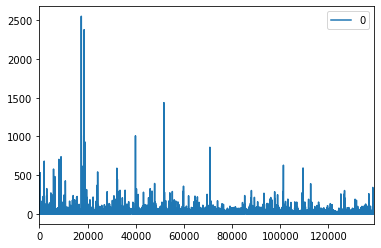

In [ ]:
# 문장수 분포
sent_cnt_df = pd.DataFrame(sent_cnt)
sent_cnt_df.plot()

In [ ]:
sent_cnt_df.describe()

,0
count,139032.000000
mean,15.903195
std,20.987063
min,0.000000
25%,8.000000
50%,14.000000
75%,20.000000
max,2551.000000


In [ ]:
data.loc[sent_cnt_df[0] > 20, 'contents']

2         [깊은 겨울 추위 속에도 창가에서면, 이 따뜻한 햇살 안에 어둠처럼 웅크린, 주기적...
3         [필연적으로 기우는 벼랑에서도, 너를 목말라하였기에, 나는 너를 위하여 울 수 있었...
4         [미시령 깊은 계곡, 어느 이름 모를 골짜기로 들어가, 존재의 고독을 잊고, 아름아...
19        [월은 돌아오는 달, , 조회 수,  시인, 추수감사절 송, 월은 돌아오는 달,  ...
25        [산간마을에서, 산간의 하루해는, 산과 산을 건너뛴다, 중천에 걸렸다 싶었는데, 어...
                                ...                        
138988    [올 봄에도, 당신 마음 여기 와 있어요, 여기 이렇게 내 다니는 길가에 꽃들 피어...
138990    [좋은 건 사라지지 않는다, 비통한 이별이나, 빼앗긴 보배스러움, 사별한 참사람도,...
139001    [사평역에서, 막차는 좀처럼 오지 않았다, 대합실 밖에는 밤새 송이눈이 쌓이고, 흰...
139011    [그대여 그립다는 말을 아십니까, 그 눈물겨운 흔들림을 아십니까, 오늘도 어김없이 ...
139019    [햇살이 맑아 그대가 생각났습니다, 비가 내려 그대가 또 생각났습니다, 전철을 타고...
Name: contents, Length: 32613, dtype: object

In [ ]:
data.loc[sent_cnt_df[0] < 5, 'contents']

22        [사랑했던 부피만큼, 그리움의 본질이다, 사랑은 아름다운 영혼으로, 상대를 바라보는...
50                        [이 어둠에선, 어느 누구도, 나와 함께할 수 없다는 것을]
70                                                       []
90                                 [마음 혹간, 네 곁으로, 다시 돌아 가는]
110                                           [오프라 윈프라, , ]
                                ...                        
139023    [스물 셋 청춘의 문밖에 떡하니 내다 건 사랑의 문패 그 문패를 보고 얼마나 많은 ...
139024    [새벽에 깨어나 반짝이는 별을 보고 있으면 이 세상 깊은 어디에 마르지 않는 사랑의...
139025    [초대받지 못한 잔치에서 초대받지 않은 손님으로 두 다리를 세워두기란 불 가마 앞에...
139026                  [부수네하늘 나는 돌 위에 절 하나 짓네마지부처에게 올리는 밥]
139028    [언제나 당신은 저만치에만 있습니다, 언젠가 한번 당신이 나에게 일러 준 듯한 당신...
Name: contents, Length: 19456, dtype: object

In [ ]:
data.loc[(sent_cnt_df[0] >= 5) & (sent_cnt_df[0] <= 20), 'contents']

0         [은빛하늘 하얀 꿈, 하얀 둥지 틀고, 아장아장 작은 설렘, 첫눈이 내린다, 소복소...
1         [비 오는 저 들녘, 눈 내리는 어둑한 골목, 바람부는 환장할 공터, 펄럭이는 깃발...
5         [가을이란 이름으로, 이 땅에 내려와 나뒹굴던, 빛 짠한 낙엽의 상처를 보듬어서, ...
6         [우리 중에 누가, 홀가분한 왕복표를, 끊을 수 있을까, 돌아오지 못할 가을을, 예...
7         [나는 나를 볼 수 없고, 너는 너를 볼 수 없다, 언제나 마주 보아야, 볼 수 있...
                                ...                        
139021    [빛고운 날 은빛 세상속으로 그대 고운 웃음을 파닥입니다 이 세상 모든 아름다운 것...
139027    [나는 내가 부족한 나무라는 걸 안다 내딴에는 곧게 자란다 생각했지만 어떤 나무는 ...
139029    [어서 하마를 치워야 할텐데 저 하마를 밖으로 끌어내야 할텐데 늦장마 끝나고 서늘한...
139030    [돌아보면 언제나 혼자였다, 나에게서 물러선 그대에게, 다시 다가가면, 그가 부담스...
139031    [살아가면서 많은 것이 묻혀지고 잊혀진다 하더라도 그대 이름만은 내 가슴에 남아 있...
Name: contents, Length: 86963, dtype: object

- 5이상 20 미만으로 결정

In [ ]:
data = data.loc[(sent_cnt_df[0] >= 5) & (sent_cnt_df[0] <= 20)].reset_index(drop=True)

In [ ]:
data = data.iloc[:, 1:]
data

,title,writer,contents,author
0,동시/첫눈 오는 날.,장수남,"[은빛하늘 하얀 꿈, 하얀 둥지 틀고, 아장아장 작은 설렘, 첫눈이 내린다, 소복소...",장수남
1,"그리움, 너는",고은영,"[비 오는 저 들녘, 눈 내리는 어둑한 골목, 바람부는 환장할 공터, 펄럭이는 깃발...",고은영
2,감잎을 쓸어 모으며,김동기,"[가을이란 이름으로, 이 땅에 내려와 나뒹굴던, 빛 짠한 낙엽의 상처를 보듬어서, ...",김동기
3,겨울행 열차,임영준,"[우리 중에 누가, 홀가분한 왕복표를, 끊을 수 있을까, 돌아오지 못할 가을을, 예...",임영준
4,착각,이남일,"[나는 나를 볼 수 없고, 너는 너를 볼 수 없다, 언제나 마주 보아야, 볼 수 있...",이남일
...,...,...,...,...
86958,그대 아름다운 날에,poemlove,[빛고운 날 은빛 세상속으로 그대 고운 웃음을 파닥입니다 이 세상 모든 아름다운 것...,정형근
86959,가죽나무,poemlove,[나는 내가 부족한 나무라는 걸 안다 내딴에는 곧게 자란다 생각했지만 어떤 나무는 ...,도종환
86960,물먹는 하마,관리자,[어서 하마를 치워야 할텐데 저 하마를 밖으로 끌어내야 할텐데 늦장마 끝나고 서늘한...,강문숙
86961,혼자 일 수 밖에 없었던 이유,poemlove,"[돌아보면 언제나 혼자였다, 나에게서 물러선 그대에게, 다시 다가가면, 그가 부담스...",이용채


In [ ]:
data.to_csv("/content/drive/My Drive/tobigs/poetry_generater/preprocessing/data.csv",encoding='utf-8')

In [ ]:
data = pd.read_csv("/content/drive/My Drive/tobigs/poetry_generater/preprocessing/data.csv",encoding='utf-8')

In [ ]:
data.head()

,Unnamed: 0,title,writer,contents,author,max_line_len_word
0,0,동시/첫눈 오는 날.,장수남,"['은빛하늘 하얀 꿈', '하얀 둥지 틀고', '아장아장 작은 설렘', '첫눈이 내...",장수남,10
1,1,"그리움, 너는",고은영,"['비 오는 저 들녘', '눈 내리는 어둑한 골목', '바람부는 환장할 공터', '...",고은영,17
2,2,감잎을 쓸어 모으며,김동기,"['가을이란 이름으로', '이 땅에 내려와 나뒹굴던', '빛 짠한 낙엽의 상처를 보...",김동기,18
3,3,겨울행 열차,임영준,"['우리 중에 누가', '홀가분한 왕복표를', '끊을 수 있을까', '돌아오지 못할...",임영준,14
4,4,착각,이남일,"['나는 나를 볼 수 없고', '너는 너를 볼 수 없다', '언제나 마주 보아야',...",이남일,12


In [ ]:
data = data.iloc[:, 1:]

In [ ]:
data["contents_re"] = data['contents'].apply(lambda x : [ i.strip() for i in x[2:-2].replace("'", '').split(",")])

In [ ]:
data["max_line_len_word"] = data.contents_re.apply(lambda x : max([len(i) for i in x]))

In [ ]:
data["max_line_len_word"].describe()

count    86963.000000
mean        30.841231
std         43.045921
min          0.000000
25%         16.000000
50%         20.000000
75%         27.000000
max       1970.000000
Name: max_line_len_word, dtype: float64

In [ ]:
data = data.sort_values("max_line_len_word", ascending=False)

In [ ]:
data = data[data['max_line_len_word'] != 0]

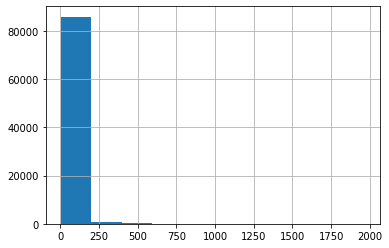

In [ ]:
data["max_line_len_word"].hist()

- 이상치 제거

In [ ]:
Q1 = np.percentile(data.max_line_len_word, 25, 0)
Q3 = np.percentile(data.max_line_len_word, 75, 0)
IQR = Q3-Q1
(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

(-0.5, 43.5)

In [ ]:
data = data[data['max_line_len_word'] < 44]

In [ ]:
data.max_line_len_word.describe()

count    75680.000000
mean        20.225330
std          6.868317
min          2.000000
25%         16.000000
50%         19.000000
75%         23.000000
max         43.000000
Name: max_line_len_word, dtype: float64

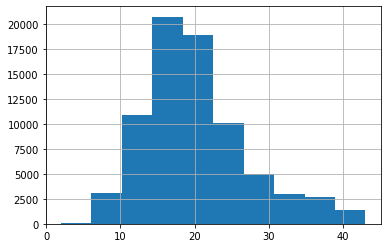

In [ ]:
data["max_line_len_word"].hist()

In [ ]:
data["total_len_word"] = data['contents_re'].apply(lambda x : sum([len(i) for i in x ]))

data["total_len_word"].describe()

count    75680.000000
mean       178.119146
std         77.806536
min          2.000000
25%        121.000000
50%        171.000000
75%        225.000000
max        740.000000
Name: total_len_word, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2072f06a0>,
      dtype=object)

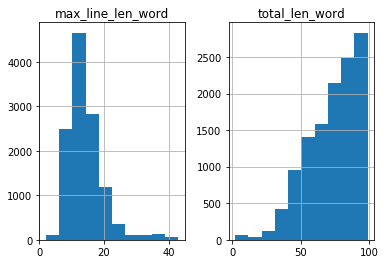

In [ ]:
data[data['total_len_word']<100].sort_values('total_len_word').hist()

- 시가 될만한 최소 길이를 직접 눈으로 확인, 전체 약 20 음절

In [ ]:
data[data['total_len_word']<20].sort_values('total_len_word').iloc[-1,:]

title                                                  법과 문학의 미래
writer                                                       자전거
contents             ['일년에 번 내는 한국의 유일한 잡지', '', '', '', '', '']
author                                                       민경대
max_line_len_word                                             19
contents_re                      [일년에 번 내는 한국의 유일한 잡지, , , , , ]
total_len_word                                                19
Name: 20831, dtype: object

In [ ]:
data[data['total_len_word']<20].sort_values('total_len_word').tail()

,title,writer,contents,author,max_line_len_word,contents_re,total_len_word
36504,인생은 외국어이다,민경대,"['모든 사람은 발음을 잘못한다', '', '', '대법원', '', '', '',...",민경대,15,"[모든 사람은 발음을 잘못한다, , , 대법원, , , , , , , ]",18
47177,두물간 처녀,가을,"[' 민조시', '안 갔지만', '처년지', '수년지', '처녀지만']",신세훈,5,"[민조시, 안 갔지만, 처년지, 수년지, 처녀지만]",18
12899,십시일반十匙一飯,민경대,"[' ', '십시일반을 영어로는 구태여 말하자면', ' ', '', '', '...",민경대,19,"[, 십시일반을 영어로는 구태여 말하자면, , , , ]",19
36398,고통,민경대,"['고통이 두드린다', '문설주에 기대어 서서', ' ', ' ', ' ', '...",민경대,11,"[고통이 두드린다, 문설주에 기대어 서서, , , , , ]",19
20831,법과 문학의 미래,자전거,"['일년에 번 내는 한국의 유일한 잡지', '', '', '', '', '']",민경대,19,"[일년에 번 내는 한국의 유일한 잡지, , , , , ]",19


- 시 전체 길이 20음절 이하 날림

In [ ]:
data = data[data['total_len_word']>=20]

data["total_len_word"].describe()

count    75579.000000
mean       178.346101
std         77.610020
min         20.000000
25%        121.000000
50%        171.000000
75%        225.000000
max        740.000000
Name: total_len_word, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd20700f358>,
      dtype=object)

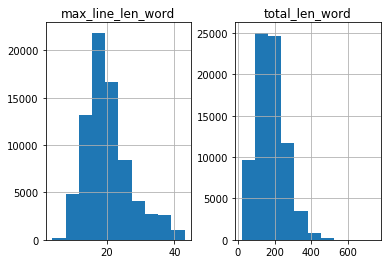

In [ ]:
data.sort_values('total_len_word').hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd206f84a20>,
      dtype=object)

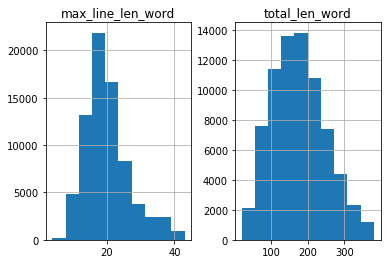

In [ ]:
Q1, Q3 = 121, 225
IQR = Q3-Q1
Q1-1.5*IQR, Q3+1.5*IQR

data = data[data["total_len_word"] < 381]

data.hist()

In [ ]:
data.max_line_len_word.describe()

data.total_len_word.describe()

count    74554.000000
mean       174.901749
std         72.100345
min         20.000000
25%        121.000000
50%        170.000000
75%        223.000000
max        380.000000
Name: total_len_word, dtype: float64

#### '게시물'이 들어간 문장 삭제

In [ ]:
from tqdm import tqdm

In [ ]:
data['del_line'] = data.total_len_word

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.contents[1]

"['풍 경', '물고기 처량하게', '쇠 된 물고기', '하릴없이 허공에다', '자기 몸을 냅다 치네', '저 물고기', '절 집을 흔들며', '맑은 물소리 쏟아내네', '문득 절 집이 물소리에 번지네', '절 집을 물고', '물고기 떠 있네 이 게시물은 님에 의해  시등록없는 시 올리기으로 부터 이동됨']"

In [ ]:
for i in tqdm(range(len(data.contents_re))):
    for j in range(len(data.contents_re[i])):
        if '게시물' in data.contents_re[i][j]:
            data['del_line'][i] = j
        else:
            data['del_line'][i] = 'None'

data['del_line']

  0%|          | 0/74554 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 74554/74554 [07:26<00:00, 166.90it/s]


0          17
1          10
2        None
3        None
4           8
         ... 
74549    None
74550    None
74551    None
74552    None
74553    None
Name: del_line, Length: 74554, dtype: object

#### 아무것도 없는 문장 삭제

In [ ]:
a = []
for i in range(len(data['del_line'])):
    if data['del_line'][i] != 'None':
        a.append(i)

In [ ]:
for i in tqdm(range(len(data.contents_re))):
    if data['del_line'][i] != 'None':
        del(data.contents_re[i][data['del_line'][i]])

100%|██████████| 74554/74554 [00:01<00:00, 67544.84it/s]


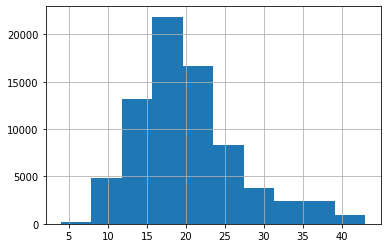

In [ ]:
data = data.reset_index(drop=True)

data["max_line_len_word"].hist()

In [ ]:
data["total_len_word"] = data['contents_re'].apply(lambda x : sum([len(i) for i in x ]))

data["total_len_word"].describe()

count    74554.000000
mean       173.471658
std         72.139752
min          0.000000
25%        119.000000
50%        168.000000
75%        221.000000
max        380.000000
Name: total_len_word, dtype: float64

In [ ]:
data["total_len_word"].sort_values()

2612       0
9485      17
510       18
66712     20
65999     20
        ... 
4682     380
5923     380
11330    380
13107    380
5839     380
Name: total_len_word, Length: 74554, dtype: int64

In [ ]:
data.to_csv("/content/drive/My Drive/tobigs/poetry_generater/preprocessing/data.csv",encoding='utf-8')

## 전처리 (2) - 토크나이징

### (1) 시 토크나이징

In [ ]:
data.head()

,title,writer,contents,author,max_line_len_word,contents_re,total_len_word,del_line
0,사랑은 어제를 모릅니다,박미화,"['자꾸만 우리는', '사랑을 추억속에만 담으려', '사랑했었다 이야기 합니다', ...",이선명,43,"[자꾸만 우리는, 사랑을 추억속에만 담으려, 사랑했었다 이야기 합니다, 하지만 사랑...",217,17
1,풍경(風磬),김재룡,"['풍 경', '물고기 처량하게', '쇠 된 물고기', '하릴없이 허공에다', '자...",서정춘,43,"[풍 경, 물고기 처량하게, 쇠 된 물고기, 하릴없이 허공에다, 자기 몸을 냅다 치...",85,10
2,청솔 아래서,관리자,"['청솔 가지에 누웠습니다', '푸른 하늘이 곱기만 하네요', '조용히 눈을 감으면...",원성스님,43,"[청솔 가지에 누웠습니다, 푸른 하늘이 곱기만 하네요, 조용히 눈을 감으면산새들 울...",194,None
3,별,정윤목,['샛별 초승달 곁 다소곳이 반짝일 때 둘이서 들길 걸으면 또드랑 풀벌레 반겨주네 ...,정윤목,43,"[샛별 초승달 곁 다소곳이 반짝일 때 둘이서 들길 걸으면 또드랑 풀벌레 반겨주네, ...",214,None
4,헛소리,묘안행,"['잠에서 튕겨나', '우두커니 앉았다', '과녁을 겨누는 자의식', '바늘 끝을 ...",강남주,43,"[잠에서 튕겨나, 우두커니 앉았다, 과녁을 겨누는 자의식, 바늘 끝을 타고 흐르는,...",80,8


In [ ]:
tokenizer = KhaiiiApi()

def contents_tokenizing(x):
  tk_list = []
  for contents in x:
    tk = []

    try:
      token = tokenizer.analyze(contents)
      for t in token:
        for m in t.morphs:
          tk += [m.lex + "/" + m.tag + "_"]

    except:
      tk += [None]
    tk_list += [tk]

  return tk_list

In [ ]:
#data_filter = pd.read_pickle("/content/drive/My Drive/Summarization/data/preprocessing/data_ppc_2_filter.pkl").loc[600000:,'contents']

ctk = data['contents_re'].apply(lambda x: contents_tokenizing(x))



NameError: ignored

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/final_poem_token.pkl', 'wb') as f:
  pickle.dump(ctk, f)
ctk

NameError: ignored

### (2) 이미지 키워드 토크나이징

In [ ]:
categorys =["beach", "cave", "island", "lake", "mountain","amusement", "palace", "park"]

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[0]), encoding='UTF-8') as f:
    js_beach = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[1]), encoding='UTF-16') as f:
    js_cave = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[2]), encoding='UTF-16') as f:
    js_island = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[3]), encoding='UTF-16') as f:
    js_lake = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[4]), encoding='UTF-8') as f:
    js_mountain = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[5]), encoding='UTF-16') as f:
    js_amusement = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[6]), encoding='UTF-16') as f:
    js_palace = json.load(f)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/{}.json'.format(categorys[7]), encoding='UTF-16') as f:
    js_park = json.load(f)


In [ ]:
classes = [js_beach, js_cave, js_island, js_lake, js_mountain,js_amusement, js_palace, js_park]

In [ ]:
for class_ in classes:
  for i in tqdm(range(len(class_))):
    class_[i]['keyword'] = contents_tokenizing(class_[i]['keyword'])

100%|██████████| 1000/1000 [00:10<00:00, 98.98it/s]


In [ ]:
categorys =["beach", "cave", "island", "lake", "mountain","amusement", "palace", "park"]

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/beach_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_beach, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/cave_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_cave, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/island_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_island, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/lake_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_lake, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/mountain_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_mountain, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/amusement_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_amusement, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/palace_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_palace, make_file, indent="\t", ensure_ascii=False)
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/park_token.json', 'w', encoding='utf-16') as make_file:
    json.dump(js_park, make_file, indent="\t", ensure_ascii=False)

# input data 만들기

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/ctk_filter_' + str(6) + '.pkl', 'rb') as f:
  ctk_pkl = pickle.load(f)

In [ ]:
ctk_pkl

0        [[은빛/NNG_, 하늘/MAG_, 하얗/VA_, ㄴ/ETM_, 꿈/NNG_], [...
1        [[비/NNG_, 오/VV_, 는/ETM_, 저/MM_, 들녘/NNG_], [눈/N...
2        [[가을/NNG_, 이/JX_, 란/ETM_, 이름/NNG_, 으로/JKB_], [...
3        [[우리/NP_, 중/NNB_, 에/JKB_, 누구/NP_, 가/JKS_], [홀가...
4        [[나/NP_, 는/JX_, 나/NP_, 를/JKO_, 보/VV_, ㄹ/ETM_, ...
                               ...                        
86958    [[빛/VV_, 고/NNG_, ㄴ/ETM_, 날/NNG_, 은빛/NNG_, 세상/N...
86959    [[나/NP_, 는/JX_, 내/NP_, 가/JKS_, 부족/NNG_, 하/XSA_...
86960    [[어서/MAG_, 하마/NNG_, 를/JKO_, 치우/VV_, 어야/EC_, 하/...
86961    [[돌아보/VV_, 면/EC_, 언제나/MAG_, 혼자/NNG_, 이/VCP_, 었...
86962    [[살아가/VV_, 면서/EC_, 많/VA_, 은/ETM_, 것/NNB_, 이/JK...
Name: contents, Length: 86963, dtype: object

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/key_hash_text_restaurant.pkl', 'rb') as f:
    restaurant_keyword = pickle.load(f)

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/key_hash_text_tower.pkl', 'rb') as f:
  tower_keyword = pickle.load(f)


In [ ]:
len(restaurant_keyword)

1000

In [ ]:
restaurant_keyword[0]['keyword']

['디저트',
 '식품',
 '케이크',
 '파이',
 '원형 (평면)',
 '과자',
 '집에서 만든',
 '어떤 사람도 없다',
 '아름다운',
 '설탕',
 '과일',
 '커스터드',
 '베이킹',
 '간식',
 '빵집',
 '아침 식사',
 '식사',
 '조리',
 '푸딩',
 '요리 전문',
 '간식',
 '쉐아라',
 '열려있어요']

In [ ]:
restaurant_keyword_token = []
for i in range(len(restaurant_keyword)):
  restaurant_keyword_token.append(contents_tokenizing(restaurant_keyword[i]['keyword']))

NameError: ignored

In [ ]:
restaurant_keyword_token[0]

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/restaurant_keyword_token.pkl', 'wb') as f:
  pickle.dump(restaurant_keyword_token, f)

In [ ]:
tower_keyword_token = []
for i in range(len(tower_keyword)):
  tower_keyword_token.append(contents_tokenizing(tower_keyword[i]['keyword']))

In [ ]:
with open('/content/drive/My Drive/tobigs/poetry_generater/preprocessing/tower_keyword_token.pkl', 'wb') as f:
  pickle.dump(tower_keyword_token, f)

In [ ]:
# 형태소 분석 토큰
with open('/content/drive/My Drive/tobigs/poetry_generater/korbert/vocab.korean_morp.list', 'r') as f:
  kor_morp = f.readlines()

kor_morp = kor_morp[2:]

In [ ]:
# 모델
model = torch.load("/content/drive/My Drive/tobigs/poetry_generater/korbert/pytorch_model.bin")

In [ ]:
model['bert.embeddings.word_embeddings.weight'].size()

torch.Size([30349, 768])

### data preparing class

In [ ]:
import pandas as pd
import json
import torch
import re
import pickle
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook
import kss

tokenizer = KhaiiiApi()

In [ ]:
class DataPreparing:
  def __init__(self):
    # dataset
    self.word2count = {}
    self.n_OOV = 0
  
    # korbert
    self.word2idx_dict = {}
    self.idx2word_dict = {}

  ## input data 생성
  def sentenceSplit(self, text):
    sntc_list = kss.split_sentences(text)
    sntc_list2 = list(filter(None, [re.sub("[^가-힣\.\?\!\s]", "", sntc) for sntc in sntc_list]))
    return sntc_list2

  def tokenizing(self, text):    
    tk_list = []
    for contents in text:
      tk = []

      try:
        token = tokenizer.analyze(contents)
        for t in token:
          tk += [m.lex + "/" + m.tag + "_" for m in t.morphs]

      except:
        tk += [None]
      tk_list += [tk]

    return tk_list

  def input_gen(self, text):
    text = self.sentenceSplit(text)
    return self.tokenizing(text)


  ## 학습데이터 생성
  def index_dict(self, pretrained_morp_list):
    for idx, morp in enumerate(pretrained_morp_list):
      morp = re.split("\t|\n", morp)[0]
      self.word2idx_dict[morp] = idx
      self.idx2word_dict[idx] = morp

  def input2index(self, doc_token):
    sntc_idx_list = []
    for sentence in doc_token:
      sntc_idx_list += [[self.word2idx_dict[token] if (token in self.word2idx_dict.keys()) else self.word2idx_dict['[UNK]'] for token in sentence]]

    return sntc_idx_list

In [ ]:
[[1,324,1451,443,63,345,0,0,0,0,0],
  [],
  [],
  [],
  []],
 [[],[],[],[],[]],
 [[],[],[],[],[]],
 [[],[],[],[],[]]
                                                                                                                                

In [ ]:
dataPrep = DataPreparing()
dataPrep.index_dict(kor_morp)

word2idx = dataPrep.word2idx_dict
idx2word = dataPrep.idx2word_dict

In [ ]:
a = dataPrep.input2index(ctk_pkl[0])

In [ ]:
text = '''트럼프 미국 대통령이 자신의 최대 업적으로 내세워온 게 불법 이민자를 막겠다며 미국과 멕시코 사이에 세운 거대한 장벽이죠. "사실상 뚫을 수 없다"며 트럼프 대통령은 이 장벽을 슈퍼카 '롤스로이스'에 빗대기도 했었는데요. 그런데 11조 원을 들여 지은 이 장벽이 11만 원짜리 싸구려 전기톱에 뚫렸다고 워싱턴 포스트가 보도했습니다.'''

In [ ]:
dataPrep.input2index(dataPrep.input_gen(text))

[[6073,
  138,
  166,
  16,
  170,
  13,
  723,
  8103,
  28,
  3341,
  20,
  399,
  10,
  33,
  16,
  1763,
  1,
  19,
  1300,
  124,
  1738,
  138,
  46,
  3302,
  549,
  14,
  1166,
  10,
  4184,
  42,
  10,
  9773,
  15,
  757,
  7],
 [283,
  462,
  5404,
  93,
  55,
  70,
  1738,
  435,
  1,
  166,
  21,
  80,
  9773,
  11,
  6725,
  1,
  1,
  300,
  14,
  1,
  49,
  34,
  61,
  6194,
  3236,
  7],
 [1165,
  1454,
  487,
  11,
  2233,
  20,
  1086,
  45,
  80,
  9773,
  16,
  85,
  86,
  2765,
  5072,
  1,
  1,
  14,
  1,
  12,
  96,
  3993,
  3461,
  24,
  491,
  9,
  840,
  116,
  7]]

## data.txt 만들기
- title, contents 합치기
- cls, sep 추가

In [ ]:
import pandas as pd
import pickle

In [ ]:
def file_load(i):
  path = '/content/drive/My Drive/tobigs/poetry_generater/preprocessing/'
  with open(path + 'ctk_filter_' + str(i) + '.pkl', 'rb') as f:
    ctk = pickle.load(f)
  if i != 6:
    ctk = ctk[:-1]
    
  
  return ctk

In [ ]:
path = '/content/drive/My Drive/tobigs/poetry_generater/preprocessing/'

with open(path + "data.txt", "w") as f:
  with open(path + "ttk_filter.pkl", "rb") as t:
    ttk = pickle.load(t)


  print(i, " pkl 시작")
  ctk = file_load(6)
  print(i, " pkl load 완료")

  for idx in ctk.index:
    if idx % 1000 == 0:
      print(idx)
    # title = ["[CLS]"] + ttk[idx] + ["[SEP]"]

    ctk_list = []
    try:
      for c in ctk[idx]:
        contents = ["[CLS]"] + c + ["[SEP]"]
        ctk_list += [" ".join(contents)]

      f.write(" ".join(ctk_list) + "\n")
    except: pass
  del ctk
  del ctk_list

139031  pkl 시작
139031  pkl load 완료
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000


In [ ]:
import os

In [ ]:
def construct_vocab(file_, max_size=50000, mincount=5):
    vocab2id = {'[CLS]': 2, '[SEP]': 3, '[PAD]': 0, '[UNK]': 1, '[STOP]': 4}
    id2vocab = {2: '[CLS]', 3: '[SEP]', 0: '[PAD]', 1: '[UNK]', 4: '[STOP]'}
    word_pad = {'[CLS]': 2, '[SEP]': 3, '[PAD]': 0, '[UNK]': 1, '[STOP]': 4}
    
    cnt = len(vocab2id)
    with open(file_, 'r',encoding='utf-8') as fp:
        for line in fp:
            arr = re.split('\t', line[:-1])
            if (arr[0] in [' ', 'n_iters=10000', 'max_length=16', '[MASK]','<S>','<T>']) :
                continue
            if arr[0] in word_pad:
                continue
            if int(arr[1]) >= mincount:
                vocab2id[arr[0]] = cnt
                id2vocab[cnt] = arr[0]
                cnt += 1
            if len(vocab2id) == max_size:
                  break
  
    return vocab2id, id2vocab

In [ ]:
vocab2id, id2vocab = construct_vocab(file_='/content/drive/My Drive/Summarization/data/korbert/vocab.korean_morp.list')
src_vocab2id = vocab2id
src_id2vocab = id2vocab

In [ ]:
file_ = os.path.join('/content/drive/My Drive/Summarization/data', 'batch_'+'test'+'_'+str(16), str(0))
fp = open(file_, 'r')

In [ ]:
trg_arr = []
src_lens = []
trg_lens = []
for line in fp:
    arr = re.split('<sec>', line[:-1])
    dabs = re.split('\s', arr[1])
    dabs = list(filter(None, dabs)) + ['[STOP]']
    trg_lens.append(len(dabs))
    
    dabs2id = [
        src_vocab2id[wd] if wd in src_vocab2id
        else src_vocab2id['[UNK]']
        for wd in dabs
    ]
    trg_arr.append(dabs2id)

In [ ]:
len(trg_arr)

15

In [ ]:
src_vocab2id

In [ ]:
for line in fp:
    arr = re.split('<sec>', line[:-1])

In [ ]:
arr

['[CLS] 변비/NNG_ 때문/NNB_ 에/JKB_ 아랫배/NNG_ 가/JKS_ 나오/VV_ ㄴ다/EF_ ?/SF_ ‘/SS_ 변비/NNG_ ’/SS_ 에/JKB_ 관하/VV_ ㄴ/ETM_ 속설/NNG_ 4/SN_ 가지/NNB_ ’/SS_ [SEP]',
 '[CLS] 변비/NNG_ 로/JKB_ 고생/NNG_ 하/XSV_ 는/ETM_ 분/NNB_ 들/XSN_ 이/JKS_ 참/MAG_ 많/VA_ 습니다/EC_ [SEP] [CLS] 배/NNG_ 의/JKG_ 묵직/XR_ 하/XSA_ ㅁ/ETN_ 과/JC_ 답답/XR_ 하/XSA_ ㄴ/ETM_ 변비/NNG_ 로/JKB_ 인하/VV_ ㄴ/ETM_ 스트레스/NNG_ 등/NNB_ 다양/NNG_ 하/XSA_ ㄴ/ETM_ 고통/NNG_ 을/JKO_ 겪/VV_ 게/EC_ 되/VV_ ㅂ니다/EC_ [SEP] [CLS] 그런데/MAJ_ 흔히/MAG_ 변비/NNG_ 때문/NNB_ 에/JKB_ 아랫배/NNG_ 가/JKS_ 나오/VV_ ㄴ다고/EC_ 생각/NNG_ 하/XSV_ 거나/EC_ 변비/NNG_ 때문/NNB_ 에/JKB_ 살/NNG_ 이/JKS_ 더/MAG_ 찌/VV_ ㄴ다/EC_ 이/VCP_ 라고/EC_ 생각/NNG_ 하/XSV_ 는/ETM_ 사람/NNG_ 들/XSN_ 이/JKS_ 많/VA_ 습니다/EC_ [SEP] [CLS] 정말/MAG_ 그렇/VA_ ㄹ까요/EC_ [SEP] [CLS] 떠돌/VV_ 는/ETM_ 이야기/NNG_ 와/JKB_ 달리/MAG_ 과장/NNG_ 되/XSV_ ㄴ/ETM_ 부분/NNG_ 이/JKS_ 많/VA_ 습니다/EC_ [SEP] [CLS] 오늘/NNG_ 은/JX_ 떠돌/VV_ 는/ETM_ 속설/NNG_ 을/JKO_ 한솔병원/NNP_ 대장/NNG_ 항문외/NNG_ 과/JC_ 강동우/NNP_ 전문의/NNG_ 의/JKG_ 도움말/NNG_ 을/JKO_ 통하/VV_ 여/EC_ 속/NNG_ 시원/XR_ 하/XSA_ 게/EC_ 풀/VV_ 어/EC_ 보/VX_ 도록/EC_ 하/VX_ 겠/EP_ 습니다/EC_ [S

In [ ]:
line

'[CLS] 변비/NNG_ 때문/NNB_ 에/JKB_ 아랫배/NNG_ 가/JKS_ 나오/VV_ ㄴ다/EF_ ?/SF_ ‘/SS_ 변비/NNG_ ’/SS_ 에/JKB_ 관하/VV_ ㄴ/ETM_ 속설/NNG_ 4/SN_ 가지/NNB_ ’/SS_ [SEP]<sec>[CLS] 변비/NNG_ 로/JKB_ 고생/NNG_ 하/XSV_ 는/ETM_ 분/NNB_ 들/XSN_ 이/JKS_ 참/MAG_ 많/VA_ 습니다/EC_ [SEP] [CLS] 배/NNG_ 의/JKG_ 묵직/XR_ 하/XSA_ ㅁ/ETN_ 과/JC_ 답답/XR_ 하/XSA_ ㄴ/ETM_ 변비/NNG_ 로/JKB_ 인하/VV_ ㄴ/ETM_ 스트레스/NNG_ 등/NNB_ 다양/NNG_ 하/XSA_ ㄴ/ETM_ 고통/NNG_ 을/JKO_ 겪/VV_ 게/EC_ 되/VV_ ㅂ니다/EC_ [SEP] [CLS] 그런데/MAJ_ 흔히/MAG_ 변비/NNG_ 때문/NNB_ 에/JKB_ 아랫배/NNG_ 가/JKS_ 나오/VV_ ㄴ다고/EC_ 생각/NNG_ 하/XSV_ 거나/EC_ 변비/NNG_ 때문/NNB_ 에/JKB_ 살/NNG_ 이/JKS_ 더/MAG_ 찌/VV_ ㄴ다/EC_ 이/VCP_ 라고/EC_ 생각/NNG_ 하/XSV_ 는/ETM_ 사람/NNG_ 들/XSN_ 이/JKS_ 많/VA_ 습니다/EC_ [SEP] [CLS] 정말/MAG_ 그렇/VA_ ㄹ까요/EC_ [SEP] [CLS] 떠돌/VV_ 는/ETM_ 이야기/NNG_ 와/JKB_ 달리/MAG_ 과장/NNG_ 되/XSV_ ㄴ/ETM_ 부분/NNG_ 이/JKS_ 많/VA_ 습니다/EC_ [SEP] [CLS] 오늘/NNG_ 은/JX_ 떠돌/VV_ 는/ETM_ 속설/NNG_ 을/JKO_ 한솔병원/NNP_ 대장/NNG_ 항문외/NNG_ 과/JC_ 강동우/NNP_ 전문의/NNG_ 의/JKG_ 도움말/NNG_ 을/JKO_ 통하/VV_ 여/EC_ 속/NNG_ 시원/XR_ 하/XSA_ 게/EC_ 풀/VV_ 어/EC_ 보/VX_ 도록/EC_ 하/VX_ 겠/EP_ 습니다/EC_ [SE

In [ ]:
for line in fp:
  li

In [ ]:
for line in fp:
    arr = re.split('<sec>', line)

In [ ]:
dabs = re.split('\s', arr[1])

In [ ]:
len(dabs)

643

In [ ]:
dabs2 = list(filter(None, dabs)) + ['[STOP]']

In [ ]:
len(dabs2)

644

In [ ]:
dabs2id = [
    src_vocab2id[wd] if wd in src_vocab2id
    else src_vocab2id['[UNK]']
    for wd in dabs2
]

In [ ]:
len(dabs2id)

644

In [ ]:
len(trg_arr[0])

1149

## data split 
- train : validation = 8:2

In [ ]:
path = '/content/drive/My Drive/tobigs/poetry_generater/preprocessing/'
with open(path + "data.txt", "r") as f:
  data = f.readlines()

In [ ]:
len(data)

80831

In [ ]:
data

['[CLS] 은빛/NNG_ 하늘/MAG_ 하얗/VA_ ㄴ/ETM_ 꿈/NNG_ [SEP] [CLS] 하얗/VA_ ㄴ/ETM_ 둥지/NNG_ 틀/VV_ 고/EC_ [SEP] [CLS] 아장아장/MAG_ 작/VA_ 은/ETM_ 설/NNP_ 레/VV_ ㅁ/ETN_ [SEP] [CLS] 첫눈/NNG_ 이/JKS_ 내리/VV_ ㄴ다/EC_ [SEP] [CLS] 소복/NNG_ 소복/NNG_ 너/NP_ 와/JKB_ 의/JKG_ [SEP] [CLS] 초롱불/NNG_ 외할머니/NNG_ 의/JKG_ [SEP] [CLS] 길/VA_ ㄴ/ETM_ 옛/MM_ 이야기/NNG_ [SEP] [CLS] 앞마당/NNG_ 눈사람/NNG_ [SEP] [CLS] 콧수염/NNG_ 우리/NP_ 할아버지/NNG_ [SEP] [CLS] 내/NP_ 가/JKS_ 그리/MAG_ 생기/VV_ 었/EP_ 냐/EC_ [SEP] [CLS] 추억/NNG_ 하/XSV_ 나/EC_ 그립/VA_ 다/EC_ [SEP]\n',
 '[CLS] 비/NNG_ 오/VV_ 는/ETM_ 저/MM_ 들녘/NNG_ [SEP] [CLS] 눈/NNG_ 내리/VV_ 는/ETM_ 어둑/XR_ 하/XSA_ ㄴ/ETM_ 골목/NNG_ [SEP] [CLS] 바람/NNG_ 불/VV_ 는/ETM_ 환장/NNG_ 하/XSV_ ㄹ/ETM_ 공터/NNG_ [SEP] [CLS] 펄럭이/VV_ 는/ETM_ 깃발/NNG_ 이/VCP_ 여/EC_ 너/NP_ 는/JX_ [SEP] [CLS] 천형/NNG_ 의/JKG_ 지표/NNG_ 로/JKB_ 서/VV_ 어서/EC_ [SEP] [CLS] 흔들리/VV_ 지/EC_ 않/VX_ 는/ETM_ 나/XPN_ 무여/NNG_ 너/NP_ 는/JX_ [SEP] [CLS] 줄창/MAG_ 푸르/VA_ ㄴ/ETM_ 잎새/NNG_ 로/JKB_ 팔랑/VV_ 대/NNG_ 다가/EC_ [SEP] [CLS] 취하/VV_ ㄴ/ETM_ 손길/NNG_ 로/JKB_ 띄우/VV_ 는/ETM_ 안/NNP_ 부이/VV_ 어/EC_ 너/NP_ 는/JX_ [SEP] 

In [ ]:
import random

In [ ]:
random.shuffle(data)

In [ ]:
val = data[:15000]
test = data[15000:30000]
train = data[30000:]

In [ ]:
with open(path + "test.txt", "w") as f:
  for i in test:
    f.write(i)

In [ ]:
with open(path + "train.txt", "w") as f:
  for i in train:
    f.write(i)

In [ ]:
with open(path + "val.txt", "w") as f:
  for i in val:
    f.write(i)

In [ ]:

tt_len = []
ct_len = []

for d in data:
  # tt, ct = re.split("<sec>", d)
  # tt_len += [len(re.split("\s", tt))]
  ct_len += [len(re.split("\s", d))]

In [ ]:
# tt = pd.DataFrame(tt_len)
ct = pd.DataFrame(ct_len)

AxesSubplot(0.125,0.125;0.775x0.755)


,0
count,80831.000000
mean,141.029914
std,72.963939
min,21.000000
25%,96.000000
50%,132.000000
75%,170.000000
max,2197.000000


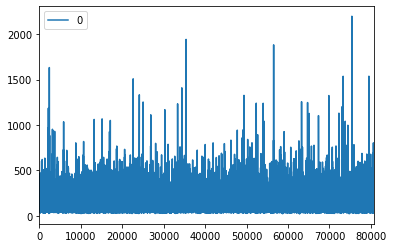

In [ ]:
print(ct.plot())
ct.describe()

In [ ]:
sum(ct[0] < 800)

80777

In [ ]:
len(ct)

80831